**Welcome to my kernel on formation analytics!! **

Let's try and learn a little bit about the formations used in Eurpoean football. Which are popular, which are effective and whatever else we can think of.  

I'll first plot and classify some of the formations and then run an exploratory data analysis to get a feel for the formations data before we dig any deeper. 

Let's jump into it!!! 

In [1]:
#Load Packages
library(RSQLite)
library(DBI)
library(tidyverse)
library(ggplot2)
library(plotly)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   1.0.0          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


The following object is masked from ‘package:httr’:

    config




In [2]:
#Connect to the db and bring in the data
#For some reason I had to download the DB onto my PC for the connect to work ... 
con <- dbConnect(SQLite(), '../input/database.sqlite')
matches <- dbGetQuery(con, 'SELECT * FROM Match')
teams <- dbGetQuery(con, 'SELECT * FROM Team')
countries <- dbGetQuery(con, 'SELECT * FROM Country')
leagues <- dbGetQuery(con, 'SELECT * FROM League')

We need to put the positional (x,y) data together into a cleaner format to prepare for analysis. 
Also, I'll formulate a home and away dataset before binding them to create a dataset with an individual result per each team.  

In [3]:
positions <- matches[,1:55]
positions <- na.omit(positions) 
home.dat <- positions[,c(1, 12:22, 34:44)]
away.dat <- positions[,c(1, 23:33, 45:55)]
home.dat <- mutate(home.dat, home.away = "home")
away.dat <- mutate(away.dat, home.away = "away")
names <- c("id", "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11",
          "Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10", "Y11", "home.away") 

names(home.dat) <- names
names(away.dat) <- names
dat <- rbind(home.dat, away.dat)

OK! Now that the positional data is ready let's run a kmeans cluster analysis to identify different formations. 

I'll arbitraily pick 35 clusters to make sure we can ID the lionshare of the formations out there

In [4]:
set.seed(1234)
cluster.dat <- select(dat, -id, -home.away)
centers <- 30
kcluster <- kmeans(cluster.dat, centers = centers)
dat$cluster <- kcluster$cluster

cluster.means <- data.frame(kcluster$centers)
cluster.means <- mutate(cluster.means, cluster = 1:centers)

head(cluster.means)


X1 X2       X3       X4       X5       X6       X7       X8       X9      
1 1  3.007557 5.007557 6.969773 1.991604 4.001679 6.018472 8.010915 3.758186
2 1  3.959184 6.204082 2.040816 7.795918 3.959184 5.081633 6.285714 3.469388
3 1  2.916667 5.027778 6.888889 3.166667 5.611111 7.861111 3.166667 5.222222
4 1  2.000000 4.005362 6.001787 7.992851 3.998213 6.016086 2.018767 7.968722
5 1  7.185185 2.074074 4.148148 6.592593 5.111111 5.888889 3.370370 5.333333
6 1  2.605634 4.704225 7.309859 4.605634 5.929577 3.183099 5.183099 6.408451
  X10      ⋯ Y3       Y4       Y5       Y6       Y7       Y8       Y9      
1 4.755668 ⋯ 3.000000 3.000000 6.998321 6.998321 6.998321 6.996641 9.435768
2 5.020408 ⋯ 3.000000 3.000000 3.000000 6.877551 7.000000 6.979592 9.346939
3 4.305556 ⋯ 3.055556 3.055556 6.111111 6.333333 6.111111 6.833333 8.027778
4 4.008937 ⋯ 3.000000 3.000000 3.000000 5.453977 5.455764 7.394996 7.408400
5 5.037037 ⋯ 3.000000 3.000000 3.000000 6.666667 6.888889 7.259259 7.703704
6 4.140845 ⋯ 3.000000 3.000000 4.943662 4.112676 6.985915 7.070423 7.422535
  Y10       Y11       cluster
1  9.924433 10.512175 1      
2  9.816327 10.224490 2      
3  9.583333 10.305556 3      
4 10.000894  9.998213 4      
5  8.888889 10.518519 5      
6 10.014085 10.197183 6

Now we've  mean (x,y) values for each of the 11 team players per team. 
Let's reorganize the data  to get an (x,y) for each cluster and player# to plot. 
With that we can plot out the formations and see what we're working with. 

clusters player.num X        Y        
1 1        1          1.000000  1.000000
2 1        10         4.755668  9.924433
3 1        11         6.146096 10.512175
4 1        2          3.007557  3.000000
5 1        3          5.007557  3.000000
6 1        4          6.969773  3.000000

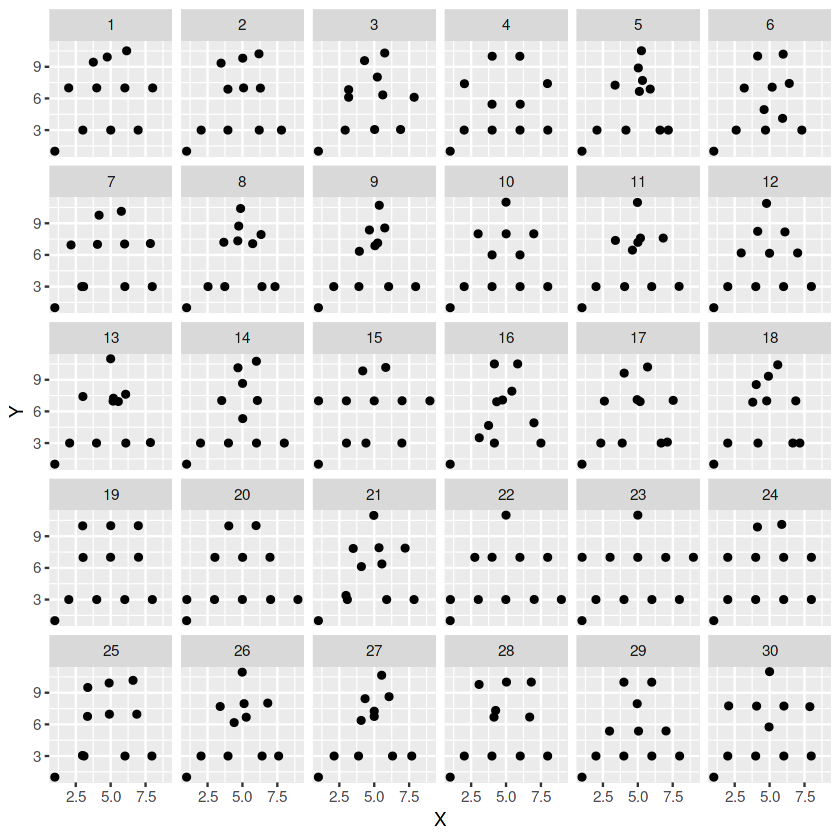

In [5]:
dat.gather <- cluster.means %>%
    gather(key = "position", value = "value", -cluster) %>%
    mutate(xy = str_extract(position, "[:upper:]")) %>%
    mutate(player.num = str_replace_all(position, "\\D", "")) %>%
    mutate(join = paste(cluster, player.num)) %>%
    spread(key = 'xy', value = 'value') 

x.dat <- dat.gather %>%
    filter(is.na(Y == TRUE)) %>%
    select(-Y)

y.dat <- dat.gather %>%
    filter(is.na(X == TRUE)) %>%
    select(-X)

cluster.data <- x.dat %>%
    left_join(y.dat, by = "join") %>%
    select(clusters = cluster.x, player.num = player.num.x, X, Y)

cluster.data <- na.omit(cluster.data)

head(cluster.data)

cluster.plot1 <- ggplot(cluster.data, aes(x= X, y=Y)) +
    geom_point() +
    facet_wrap(vars(clusters))

cluster.plot1

Let's create new columns that identify these clusters as specific formations.

Definately not a perfect art but we're generalizing on a few of these and ignoring those that are just a mass in the midfield... 


In [6]:
 dat <- dat %>% 
    mutate(form_343 = ifelse(cluster == 1, 1, 0)) %>%
    mutate(form_433 = ifelse(cluster == 19 | cluster == 2, 1, 0)) %>%
    mutate(form_4222 = ifelse(cluster == 4, 1, 0)) %>%
    mutate(form_3232 = ifelse(cluster == 6, 1, 0)) %>%
    mutate(form_4231 = ifelse(cluster == 10 | cluster == 26, 1, 0)) %>%
    mutate(form_4321 = ifelse(cluster == 12, 1, 0)) %>%
    mutate(form_41212 = ifelse(cluster == 14, 1, 0)) %>%
    mutate(form_352 = ifelse(cluster == 15, 1, 0)) %>%
    mutate(form_532 = ifelse(cluster == 20, 1, 0)) %>%
    mutate(form_541 = ifelse(cluster == 22, 1, 0)) %>%
    mutate(form_451 = ifelse(cluster == 23, 1, 0)) %>%
    mutate(form_442 = ifelse(cluster == 24, 1, 0)) %>%
    mutate(form_4312 = ifelse(cluster == 29, 1, 0)) %>%
    mutate(form_4141 = ifelse(cluster == 30, 1, 0)) %>%
    mutate(filter = form_343+ form_433 + form_4222 + form_3232 + form_4231 + form_4321 + form_41212 + 
           form_352 + form_532 + form_541 + form_451 + form_442 + form_4321 + form_4141)
  
dat.filter <- dat %>%
    filter(filter == 0) 

nrow(dat.filter)
paste(round(((nrow(dat)-nrow(dat.filter))/nrow(dat))*100,1),'% of the formations are accounted for')



[1] 2471

[1] "94.9 % of the formations are accounted for"

OK almost 95% of the formations are ID'd  --- that's great

Let's run it again just for good measure... 

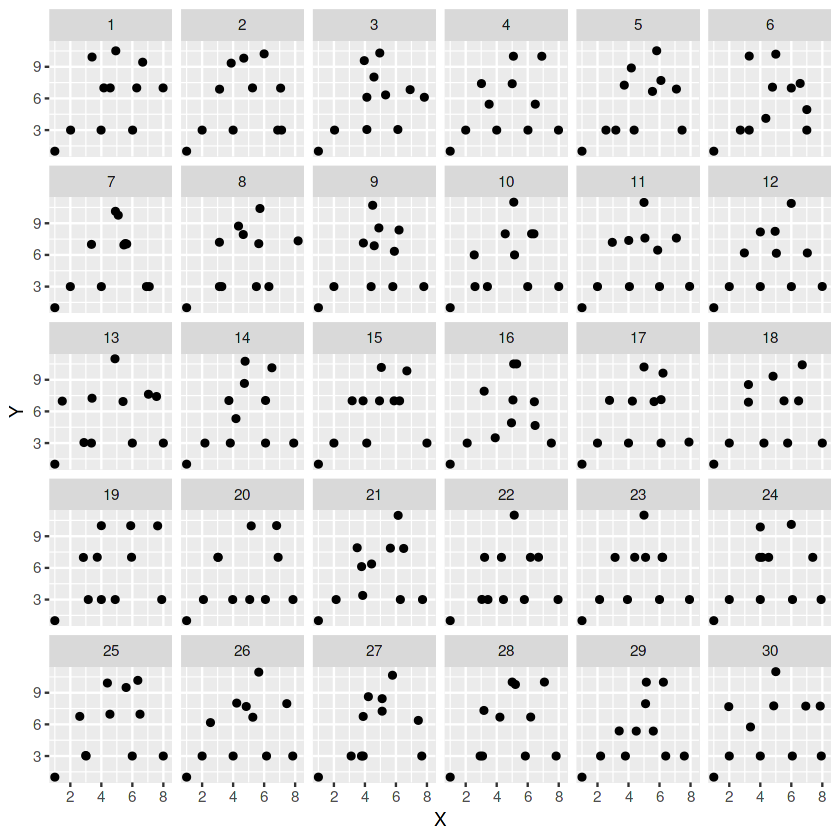

In [7]:
dat.round2 <- dat.filter[,2:23] 

centers <- 30

kcluster2 <- kmeans(dat.round2, centers = centers)
dat.filter$cluster <- kcluster2$cluster

cluster.means2 <- data.frame(kcluster2$centers)
cluster.means2 <- mutate(cluster.means2, cluster = 1:centers)

dat.gather2 <- cluster.means2 %>%
    gather(key = "position", value = "value", -cluster) %>%
    mutate(xy = str_extract(position, "[:upper:]")) %>%
    mutate(player.num = str_replace_all(position, "\\D", "")) %>%
    mutate(join = paste(cluster, player.num)) %>%
    spread(key = 'xy', value = 'value') 

x.dat2 <- dat.gather2 %>%
    filter(is.na(Y == TRUE)) %>%
    select(-Y)

y.dat2 <- dat.gather2 %>%
    filter(is.na(X == TRUE)) %>%
    select(-X)

data2 <- x.dat2 %>%
    left_join(y.dat, by = "join") %>%
    select(clusters = cluster.x, player.num = player.num.x, X, Y)

p2 <- ggplot(data2, aes(x= X, y=Y)) +
    geom_point() +
    facet_wrap(vars(clusters))

p2

As expected these are pretty wacky and can't easily be ID'd --- let's just keep them as 'other'. 

Next we'll tidy the data a little bit and add the other variables back in...

In [8]:
tidy.dat <- dat[,-(2:23)]
tidy.dat <- tidy.dat %>%
    mutate(form_other = ifelse(filter == 0, 1, 0)) %>%
    select(-filter, -cluster) %>%
    gather(key = "formation", value = "yn", -id, -home.away) %>%
    mutate(formation = str_replace_all(formation, "form_", "")) %>%
    filter(yn == 1) %>%
    select(-yn)

nrow(tidy.dat) == nrow(dat)

matches.join <- matches %>%
    select(id, country_id, league_id, season, date, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal)

leagues.join <- leagues %>%
    select(country_id, league_name= name)

teams.join <- teams %>%
    select(team_api_id, team_name = team_long_name)

dat.expand <- tidy.dat %>%
    left_join(matches.join, by = 'id') %>%
    mutate(team_api_id = ifelse(home.away == 'home', home_team_api_id, away_team_api_id)) %>%
    left_join(leagues.join, by = 'country_id') %>%
    left_join(teams.join, by = 'team_api_id') %>%
    select(-team_api_id, -away_team_api_id, -home_team_api_id, -country_id, -league_id) %>%
    mutate(draw = home_team_goal == away_team_goal) %>%
    mutate(home.win = home_team_goal > away_team_goal) %>%
    mutate(away.win = home_team_goal < away_team_goal)
    
results <- c()

for(i in 1:nrow(dat.expand)){
    if(dat.expand$home.away[i] == 'home' & dat.expand$home.win[i] == TRUE){
        results[i] <- 'win'
    }else if(dat.expand$home.away[i] == 'away' & dat.expand$away.win[i] == TRUE){
        results[i] <- 'win'
    }else if(dat.expand$draw[i] == TRUE){
        results[i] <- 'draw'
    }else{
        results[i] <- 'loss'
    }
}

dat.expand <- dat.expand %>% 
    mutate(results = results) %>%
    select(-draw, -home.win, -away.win)

points <- c()
    
for(i in 1:nrow(dat.expand)){
    if(dat.expand$results[i] == 'win'){
        points[i] <- 3
    }else if(dat.expand$results[i] == 'loss'){
        points[i] <- 0
    }else{
        points[i] <- 1
    }
}

dat.expand$points <- points
    
dat.expand <- dat.expand %>% 
    mutate(goals_for = ifelse(home.away == 'home', home_team_goal, away_team_goal)) %>% 
    mutate(goals_against = ifelse(home.away == 'away', home_team_goal, away_team_goal))


[1] FALSE

Now we've got a dataset that's ready for some exploratory formation analytics! 

Let's plot how many matches we have for each league & how many matches we have for each formation

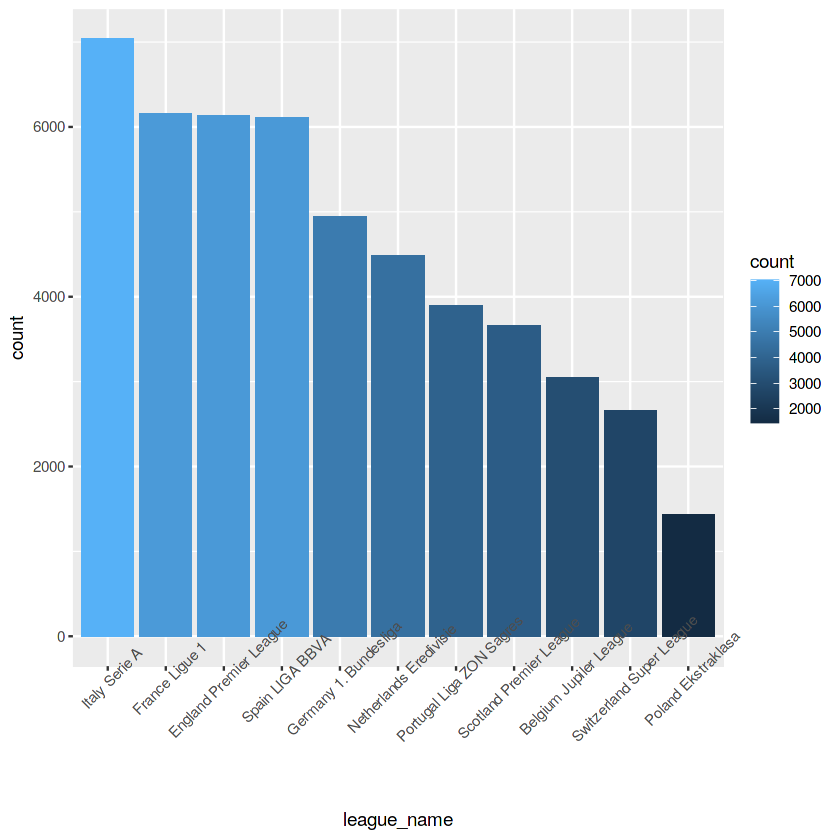

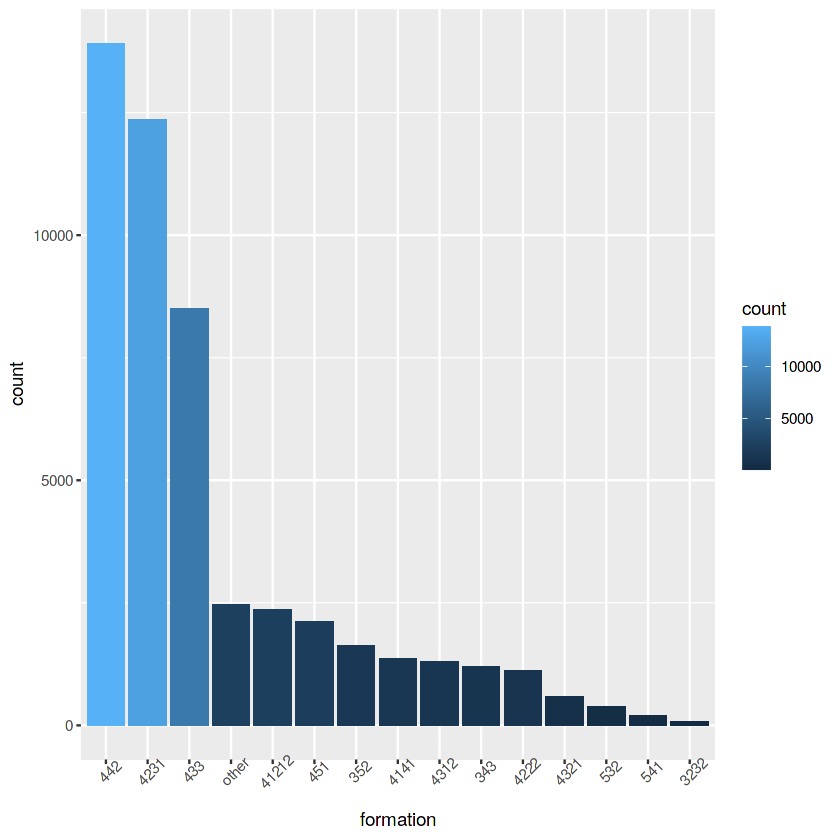

In [9]:
league.temp <- dat.expand %>%
    group_by(league_name) %>%
    summarize(count = n()) %>%
    arrange(desc(count))

league.plot <- ggplot(league.temp, aes(x = reorder(league_name, -count), y= count, fill = count)) + 
    geom_bar(stat = 'identity') +
    theme(axis.text.x = element_text(angle = 45)) + 
    xlab("league_name")

league.plot

form.temp <- dat.expand %>%
    group_by(formation) %>%
    summarize(count = n()) %>%
    arrange(desc(count))

form.plot <- ggplot(form.temp, aes(x = reorder(formation, -count), y= count, fill = count)) + 
    geom_bar(stat = 'identity')  +
    theme(axis.text.x = element_text(angle = 45)) +
    xlab('formation')

form.plot


OK so we primarily have data from the top leagues and as expected; the 4-4-2 reigns king with 4-2-3-1 and 4-3-3 trailing a bit behind. 

Let's check out some stats for each of the formations across the leagues

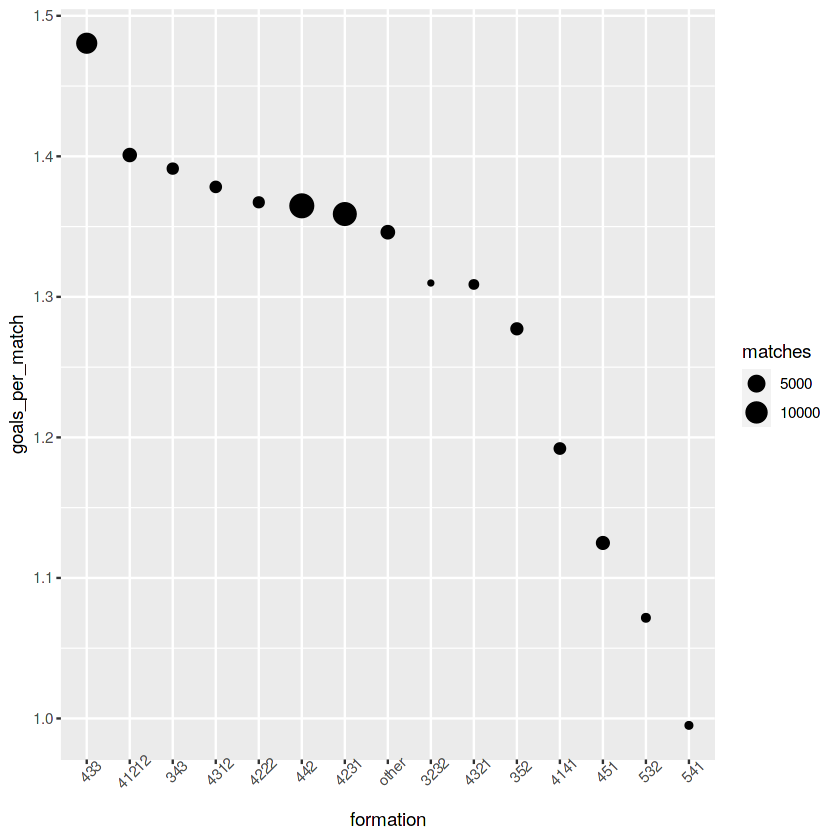

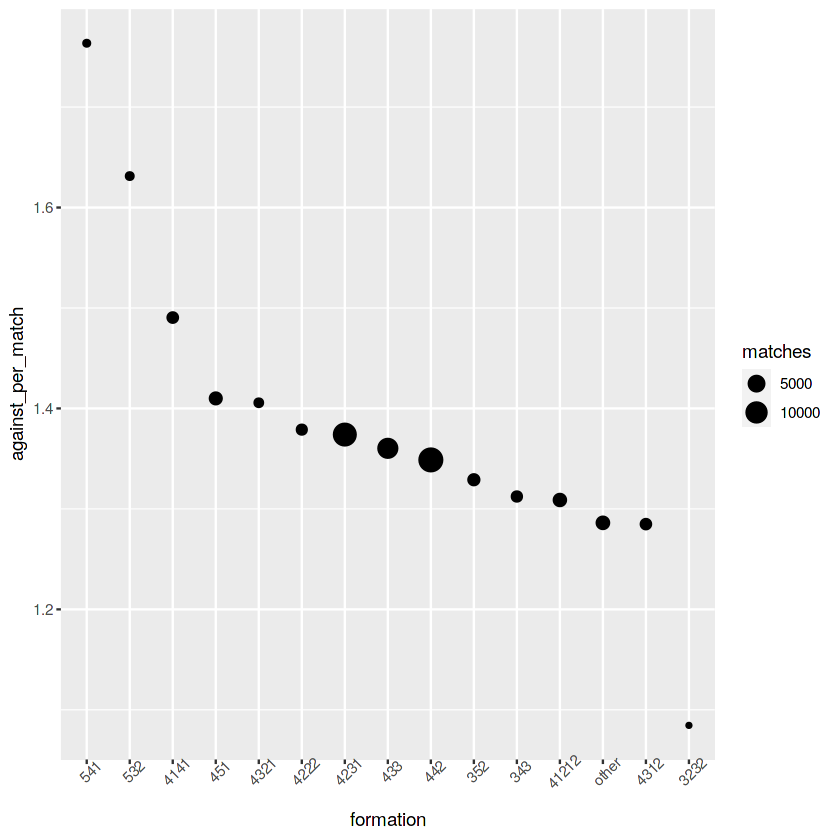

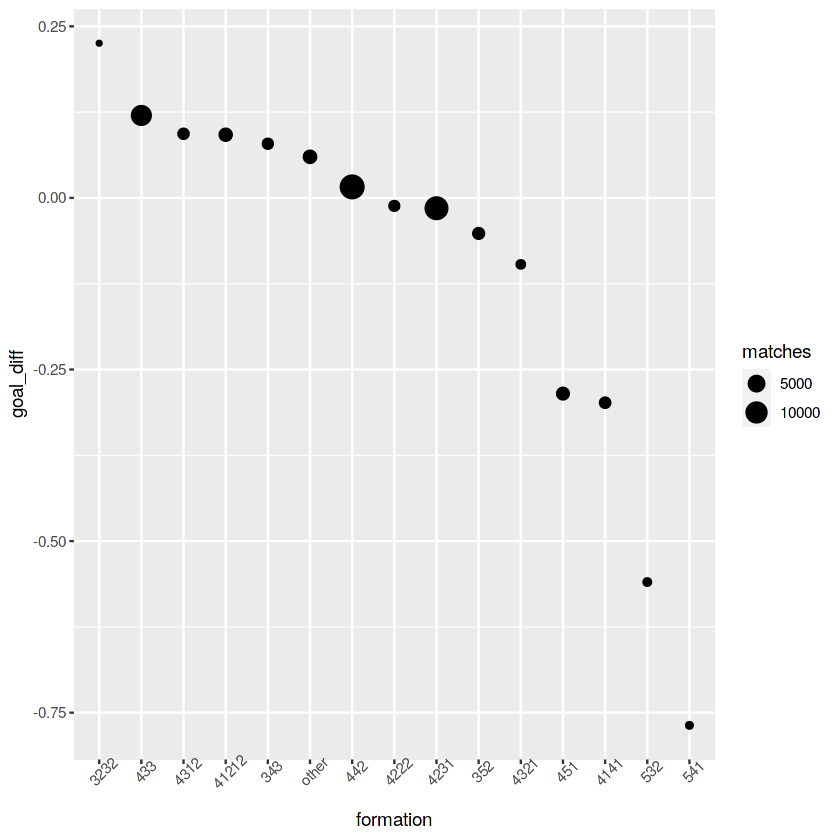

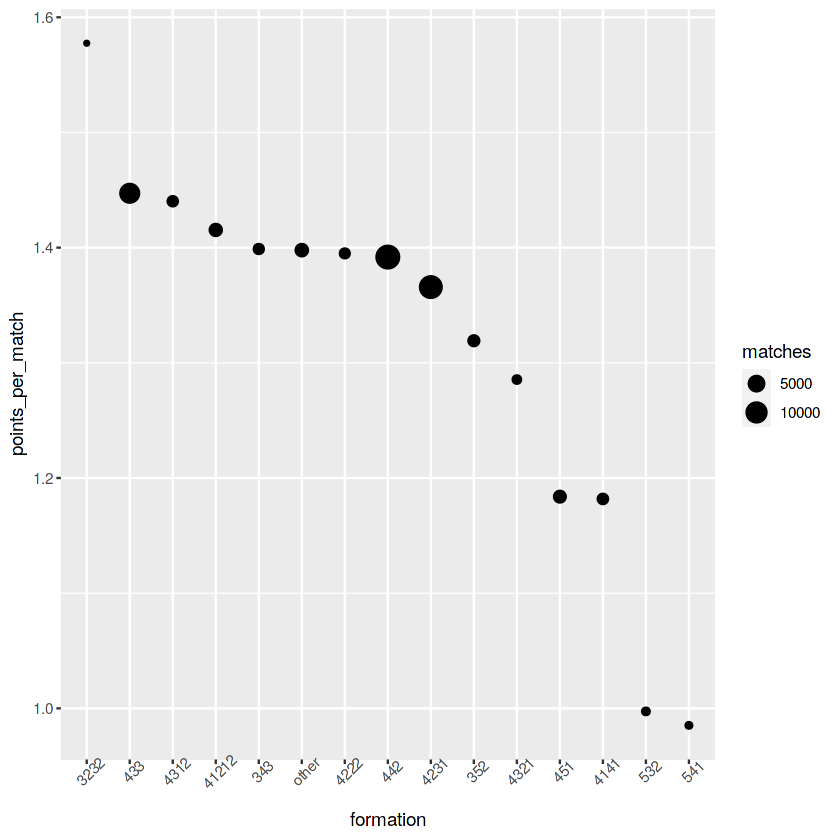

In [10]:
goal.avg <- dat.expand %>%
    group_by(formation) %>%
    summarize(matches = n(), goals_for_sum = sum(goals_for), goals_against_sum = sum(goals_against),
              goals_per_match = goals_for_sum/matches, against_per_match = goals_against_sum/matches, 
              goal_diff = goals_per_match - against_per_match, points_per_match= mean(points)) %>%
    arrange(desc(goals_per_match))

goals.for.plot <- ggplot(goal.avg, aes(x = reorder(formation, -goals_per_match), y = goals_per_match, size = matches)) +
    geom_point() + 
    xlab("goals_per_match") +
    theme(axis.text.x = element_text(angle = 45)) +
    xlab('formation')

goals.against.plot <- ggplot(goal.avg, aes(x = reorder(formation, -against_per_match), y = against_per_match, size = matches)) +
    geom_point() + 
    xlab("goals_per_match") +
    theme(axis.text.x = element_text(angle = 45))+
    xlab('formation') + 
    ylab('against_per_match')

goal.diff.plot <- ggplot(goal.avg, aes(x = reorder(formation, -goal_diff), y = goal_diff, size = matches)) +
    geom_point() + 
    xlab("goals_per_match") +
    theme(axis.text.x = element_text(angle = 45))+
    xlab('formation')

points.plot <- ggplot(goal.avg, aes(x = reorder(formation, -points_per_match), y = points_per_match, size = matches)) +
    geom_point() + 
    xlab("goals_per_match") +
    theme(axis.text.x = element_text(angle = 45))+
    xlab('formation')

goals.for.plot
goals.against.plot
goal.diff.plot
points.plot



Hmmmm... Lot's can be gleaned from these ... 

It's clear why 4-3-3 is popular - it has the most goals per game with 2nd best goal_avg and points per match. 

4-4-2 is as I would expect --- in the middle. Not too offensive and not too defensive --- a safe pick.  

5-3-2 and 5-4-1 are definately the worst. Most against, least for and weak points per match produced. 

3-2-3-2 actually has the most points per game but also has the fewest matches played at only 71. This likely needs more samples to be conclusive 


Next let's look at formation popularity over time. 

I'll seperate the figures to look at the three most popular formations. 442/4231/433

And then look at popularity of using 3 or 4 or 5 defenders over the years

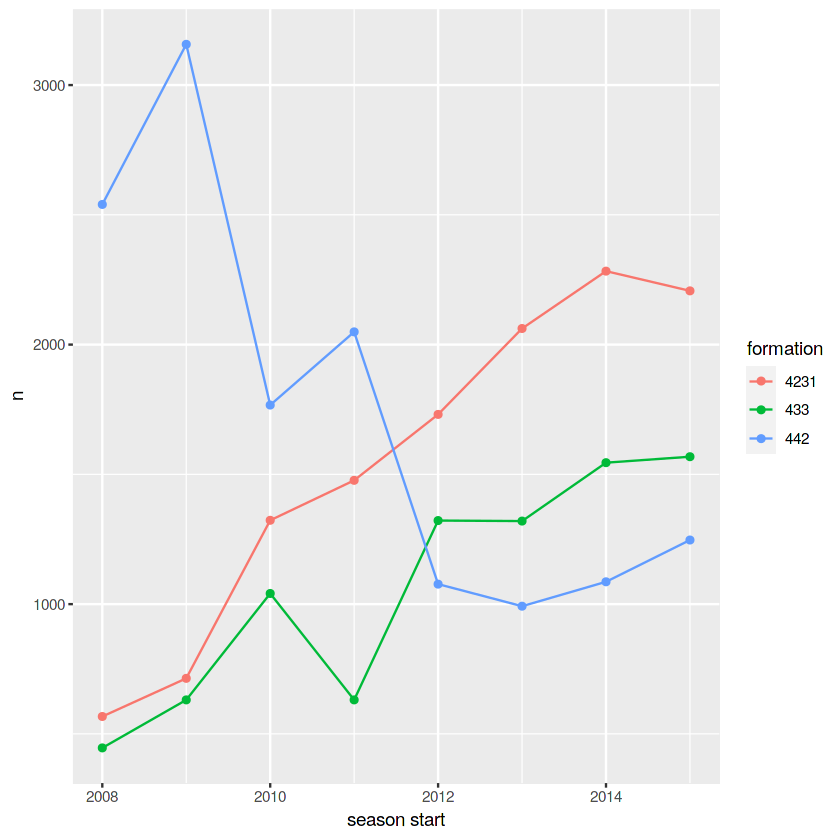

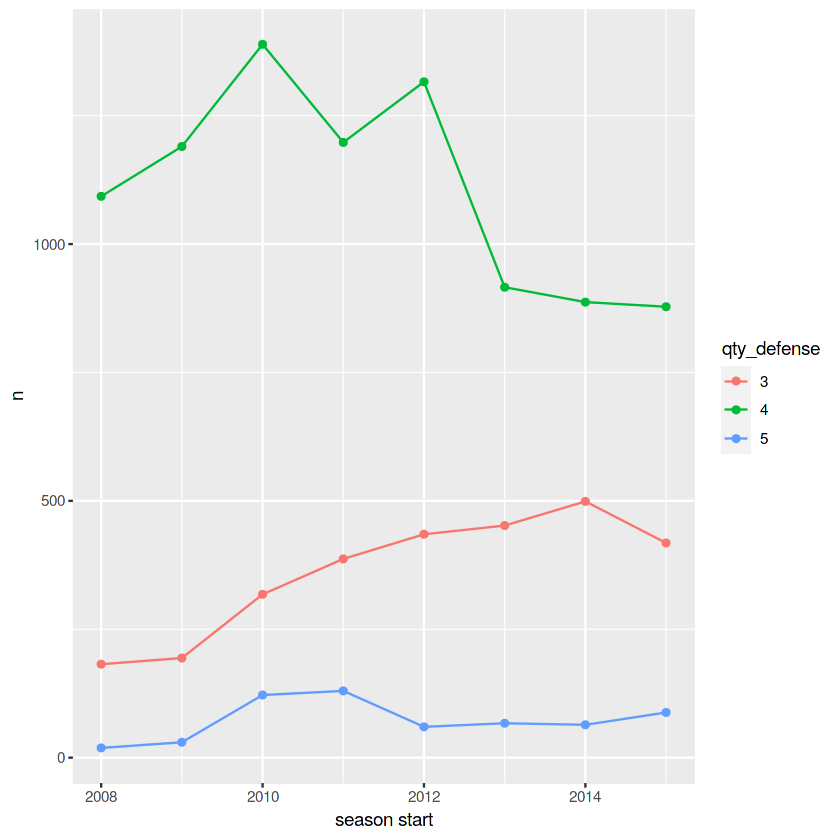

In [11]:
popularity.1 <- dat.expand %>%
    group_by(season, formation) %>%
    summarize(n = as.numeric(n())) %>%
    mutate(year.start = as.integer(str_extract(season, '\\d\\d\\d\\d'))) %>%
    filter(formation == '442' | formation == '4231' | formation == '433')

popularity.2 <- dat.expand %>%
    anti_join(popularity.1, by = "formation") %>%
    mutate(qty_defense = str_extract(formation, '\\d')) %>%
    group_by(season, qty_defense) %>%
    summarize(n = as.numeric(n())) %>%
    mutate(year.start = as.integer(str_extract(season, '\\d\\d\\d\\d')))

popularity.2 <- na.omit(popularity.2)

pop.1 <- ggplot(popularity.1, aes(x = year.start, y = n, col = formation)) +
        geom_point() +
        geom_line() +
        xlab('season start')

pop.2 <- ggplot(popularity.2, aes(x = year.start, y = n, col = qty_defense)) +
        geom_point() +
        geom_line() +
        xlab('season start')

pop.1
pop.2

4-2-3-1 and 4-3-3 are on the up and up while the 4-4-2 is on the decline. 

Looks like 4 defenders could be declining and 3 at the back is on the rise a little. 

It would be useful to see if these trends have continued into more recent years? 

Let's look at match-ups against the big three formations! 


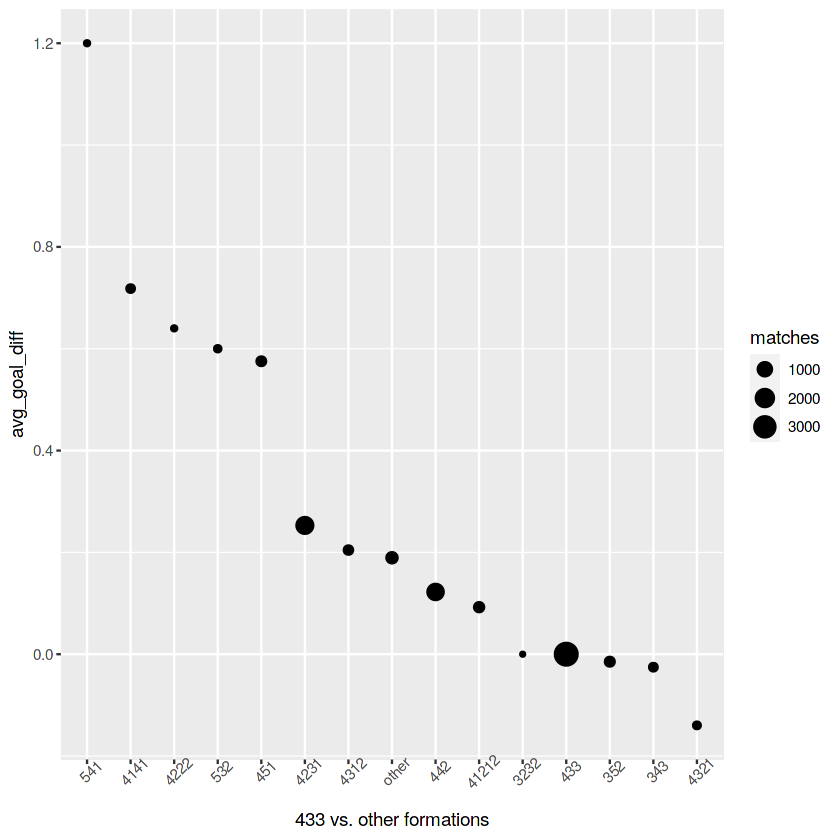

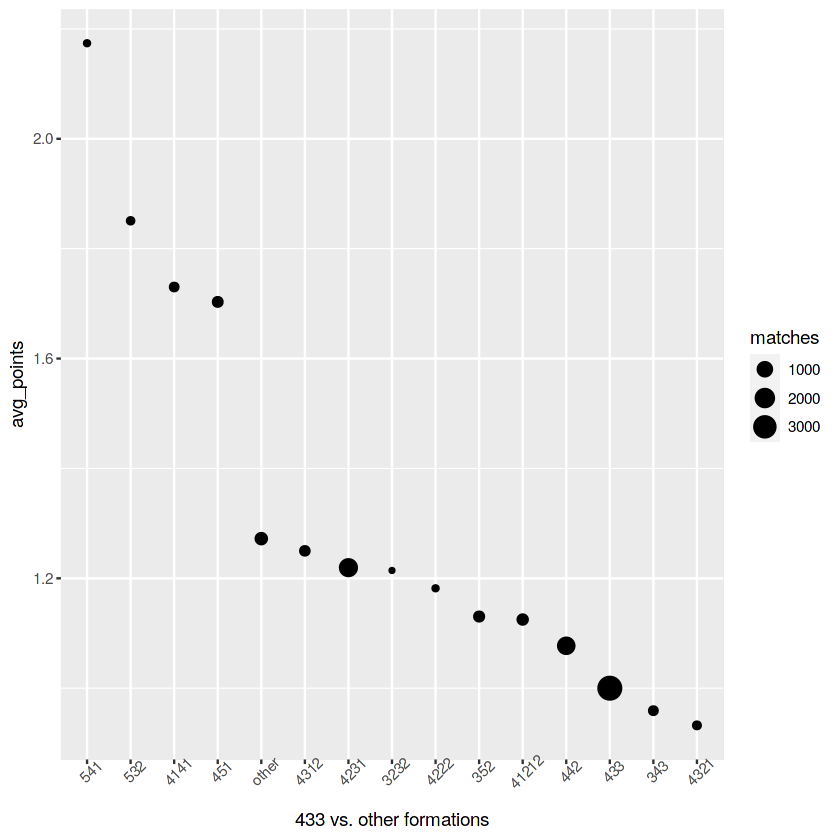

In [12]:
away <- dat.expand %>%
    filter(home.away == 'away') %>%
    select(id, away_team = team_name, away_formation = formation, away_points = points)

home <- dat.expand %>%
    filter(home.away == 'home') %>%
    left_join(away, by = 'id') %>%
    select(-home.away)

home.433 <- home %>%
    filter(formation == '433') %>%
    group_by(away_formation) %>%
    summarize(goals_for = sum(home_team_goal), goals_against = sum(away_team_goal), n= n(), points_for = sum(points), points_against = sum(away_points))

away.433 <- home %>%
    filter(away_formation == '433') %>%
    group_by(formation) %>%
    summarize(goals_for = sum(away_team_goal), goals_against = sum(home_team_goal), n= n(), points_for = sum(away_points), points_against = sum(points))

against.433 <- home.433 %>%
    full_join(away.433, by = c('away_formation' = 'formation'))

against.433[is.na(against.433)] <- 0

against.433 <- against.433 %>%
    mutate(goals_for = goals_for.x + goals_for.y, goals_against = goals_against.x + goals_against.y, n= n.x + n.y, 
           points_for = points_for.x+points_for.y, points_against = points_against.x + points_against.y) %>%
    rename(formation_against = away_formation) %>%
    group_by(formation_against) %>%
    summarize(matches = sum(n), goals_for = sum(goals_for), goals_against = sum(goals_against), 
              goals_per_match = goals_for/matches, goals_ags_match = goals_against/matches, points_for = sum(points_for), 
              points_against = sum(points_against), goal_diff = goals_per_match-goals_ags_match, points_match = points_for/points_against) %>%
    arrange(desc(points_match))

beat433.plot1 <- ggplot(against.433, aes(x = reorder(formation_against, -goal_diff), y = goal_diff, size = matches)) +
    geom_point() + 
    xlab("433 vs. other formations") +
    ylab('avg_goal_diff') + 
    theme(axis.text.x = element_text(angle = 45))

beat433.plot2 <- ggplot(against.433, aes(x = reorder(formation_against, -points_match), y = points_match, size = matches)) +
    geom_point() + 
    xlab("433 vs. other formations") +
    ylab('avg_points') + 
    theme(axis.text.x = element_text(angle = 45))

beat433.plot1
beat433.plot2

Against the effective and popular 4-3-3, the 4-2-3-1 or even 3-4-3 can put up the best challenge!

5 at the back against a 4-3-3 is not advised!

Overall, the 4-3-3 accumulates points and maintain an above goal difference against virtually every other formation.

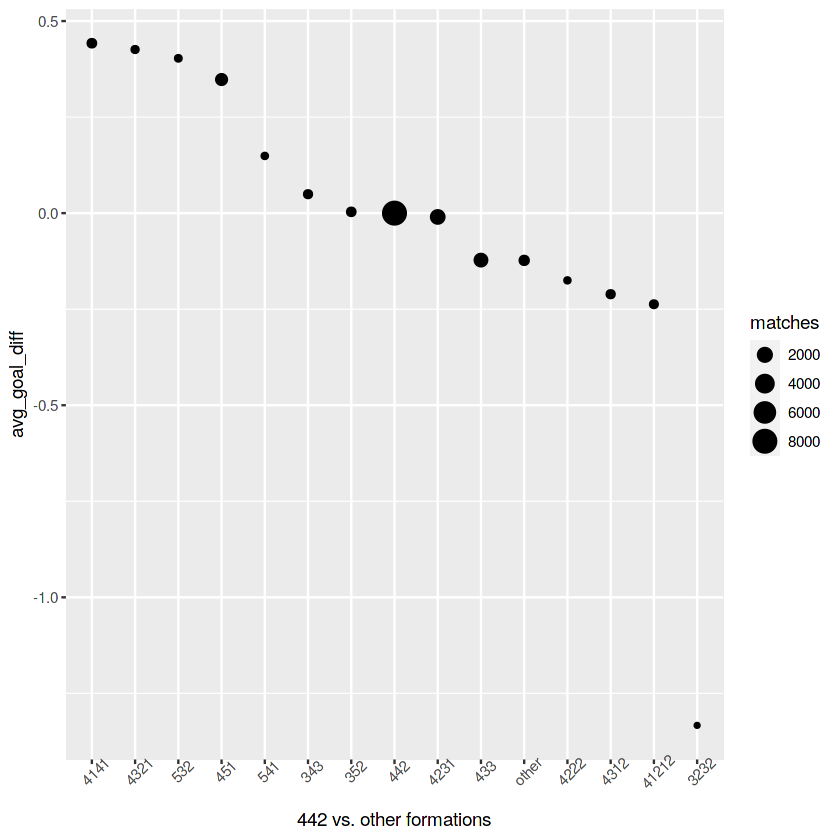

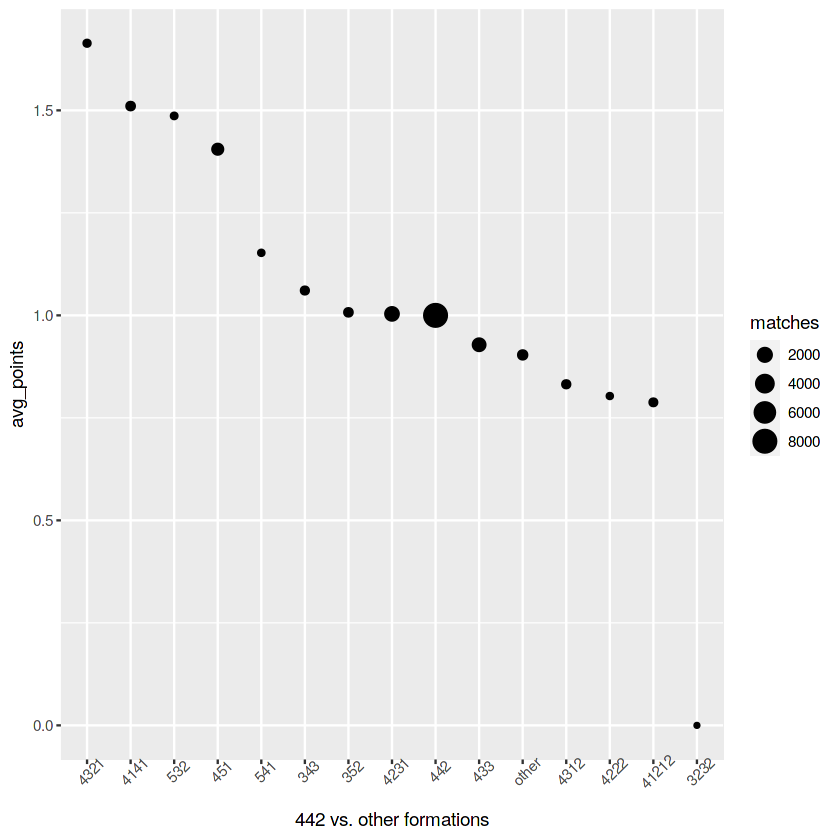

In [13]:
home.442 <- home %>%
    filter(formation == '442') %>%
    group_by(away_formation) %>%
    summarize(goals_for = sum(home_team_goal), goals_against = sum(away_team_goal), n= n(), points_for = sum(points), points_against = sum(away_points))

away.442 <- home %>%
    filter(away_formation == '442') %>%
    group_by(formation) %>%
    summarize(goals_for = sum(away_team_goal), goals_against = sum(home_team_goal), n= n(), points_for = sum(away_points), points_against = sum(points))

against.442 <- home.442 %>%
    full_join(away.442, by = c('away_formation' = 'formation'))

against.442[is.na(against.442)] <- 0

against.442 <- against.442 %>%
    mutate(goals_for = goals_for.x + goals_for.y, goals_against = goals_against.x + goals_against.y, n= n.x + n.y, 
           points_for = points_for.x+points_for.y, points_against = points_against.x + points_against.y) %>%
    rename(formation_against = away_formation) %>%
    group_by(formation_against) %>%
    summarize(matches = sum(n), goals_for = sum(goals_for), goals_against = sum(goals_against), 
              goals_per_match = goals_for/matches, goals_ags_match = goals_against/matches, points_for = sum(points_for), 
              points_against = sum(points_against), goal_diff = goals_per_match-goals_ags_match, points_match = points_for/points_against) %>%
    arrange(desc(points_match))

beat442.plot1 <- ggplot(against.442, aes(x = reorder(formation_against, -goal_diff), y = goal_diff, size = matches)) +
    geom_point() + 
    xlab("442 vs. other formations") +
    ylab('avg_goal_diff') + 
    theme(axis.text.x = element_text(angle = 45))

beat442.plot2 <- ggplot(against.442, aes(x = reorder(formation_against, -points_match), y = points_match, size = matches)) +
    geom_point() + 
    xlab("442 vs. other formations") +
    ylab('avg_points') + 
    theme(axis.text.x = element_text(angle = 45))

beat442.plot1
beat442.plot2

The classic 4-4-2!! 

it is countered best with the 4-3-3, 4-3-1-2, 4-1-2-2 or 3-2-3-2 (small sample though) 

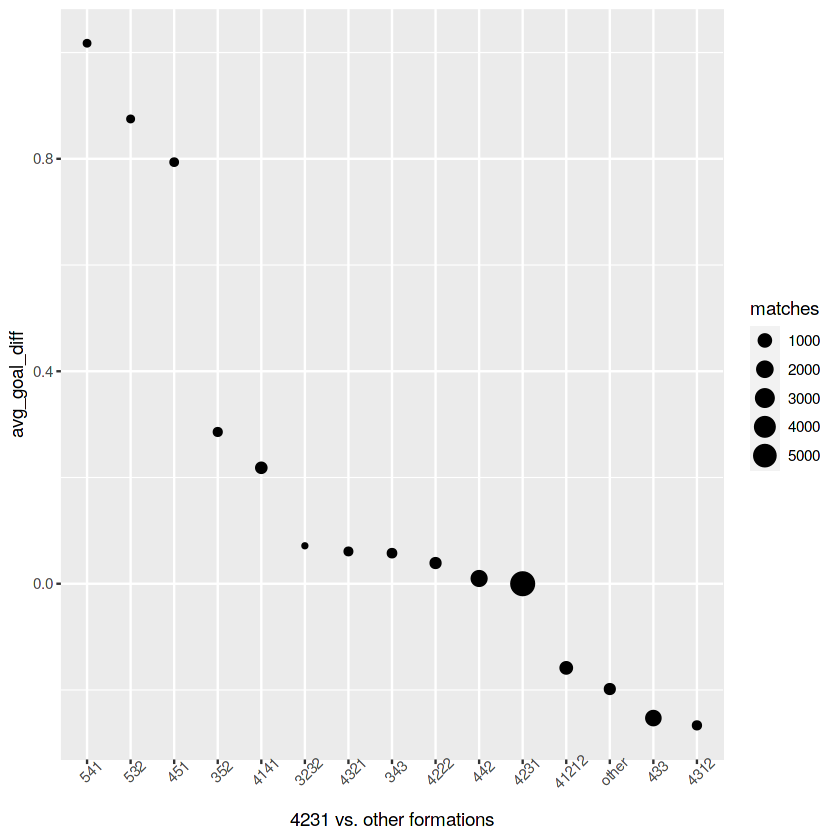

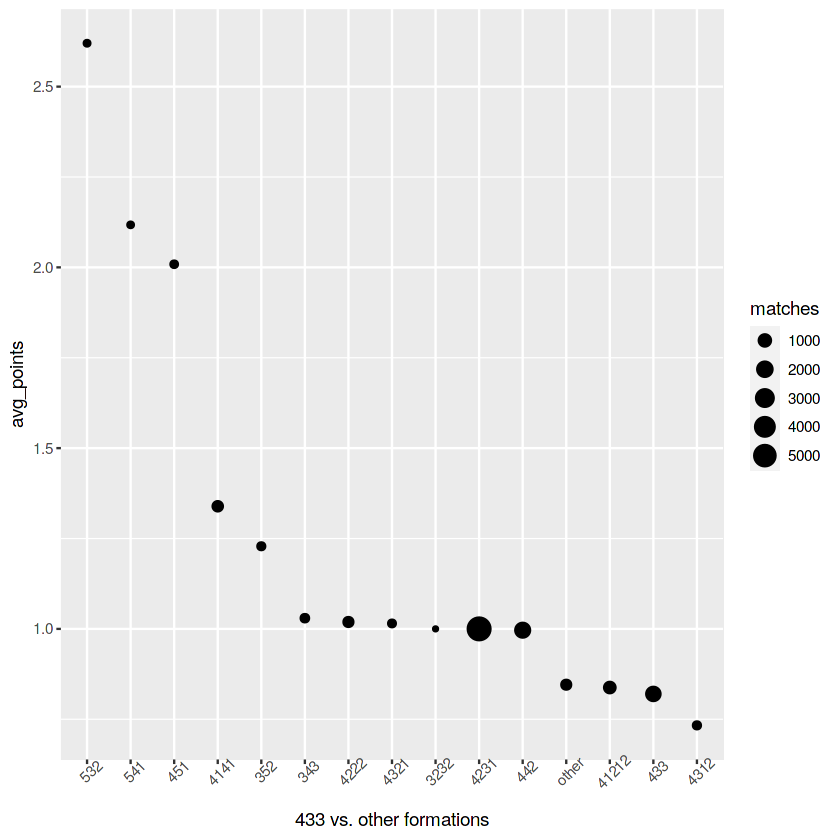

In [14]:
home.4231 <- home %>%
    filter(formation == '4231') %>%
    group_by(away_formation) %>%
    summarize(goals_for = sum(home_team_goal), goals_against = sum(away_team_goal), n= n(), points_for = sum(points), points_against = sum(away_points))

away.4231 <- home %>%
    filter(away_formation == '4231') %>%
    group_by(formation) %>%
    summarize(goals_for = sum(away_team_goal), goals_against = sum(home_team_goal), n= n(), points_for = sum(away_points), points_against = sum(points))

against.4231 <- home.4231 %>%
    full_join(away.4231, by = c('away_formation' = 'formation'))

against.4231[is.na(against.4231)] <- 0

against.4231 <- against.4231 %>%
    mutate(goals_for = goals_for.x + goals_for.y, goals_against = goals_against.x + goals_against.y, n= n.x + n.y, 
           points_for = points_for.x+points_for.y, points_against = points_against.x + points_against.y) %>%
    rename(formation_against = away_formation) %>%
    group_by(formation_against) %>%
    summarize(matches = sum(n), goals_for = sum(goals_for), goals_against = sum(goals_against), 
              goals_per_match = goals_for/matches, goals_ags_match = goals_against/matches, points_for = sum(points_for), 
              points_against = sum(points_against), goal_diff = goals_per_match-goals_ags_match, points_match = points_for/points_against) %>%
    arrange(desc(points_match))

beat4231.plot1 <- ggplot(against.4231, aes(x = reorder(formation_against, -goal_diff), y = goal_diff, size = matches)) +
    geom_point() + 
    xlab("4231 vs. other formations") +
    ylab('avg_goal_diff') + 
    theme(axis.text.x = element_text(angle = 45))

beat4231.plot2 <- ggplot(against.4231, aes(x = reorder(formation_against, -points_match), y = points_match, size = matches)) +
    geom_point() + 
    xlab("433 vs. other formations") +
    ylab('avg_points') + 
    theme(axis.text.x = element_text(angle = 45))

beat4231.plot1
beat4231.plot2

What about the Pep Guardiola 4-2-3-1? 

Similar to the 4-3-3, a 5 at the back looks weak and a 4-3-3, 4-3-1-2 or 4-1-2-1-2 looks best here! 


With that I'll close the book on this exploration for the time being! 

What's next?? 

Maybe roll in some betting odds or player ratings to attempt to 'level the playing field' of the different formations and get a deeper analysis going. 

We could also apply a little machine learning to a specific team to generate formation recomendations for each match-up! That would be pretty cool :)  

So many ideas - so little time!! 